# Requirements

In [13]:
from datasets import Dataset, DatasetDict, ClassLabel, Value
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score

# Load email data & preprocess

In [1]:
df = pd.read_csv("extracted_emails.csv")
df = pd.DataFrame(df)

dataset = Dataset.from_pandas(df)
print(dataset)

Dataset({
    features: ['id', 'label', 'subject', 'text'],
    num_rows: 6617
})


In [2]:
# define class label

new_features = dataset.features.copy()
new_features["label"] = ClassLabel(names_file="names.txt")
dataset = dataset.cast(new_features)
dataset.features

# behind the scenes: class label is int, so no need to preprocess the feature 'label' in this dataset.
# the mapping of integers to label name is stored in the names.txt file

Casting the dataset:   0%|          | 0/6617 [00:00<?, ? examples/s]

{'id': Value(dtype='string', id=None),
 'label': ClassLabel(names=['A-Levels', 'Ameen', 'apt search', 'Ayra', 'Banking & Investments/Al Meezan', 'Banking & Investments/Leads', 'Banking & Investments/Meezan', 'Banking & Investments/RBC', 'Banking & Investments/Scotia', 'Banking & Investments/Support', 'Banking & Investments/TD', 'Banking & Investments/Walmart', 'Banking & Investments/Wealthsimple', 'Banking & Investments/Wise', 'Bookings/Communauto', 'Bookings/Flights', 'Bookings/Hotel', 'Bookings/Transport', 'DOCS', 'Events & Tickets', 'Food & Shopping/Cancellations/Refunds', 'Food & Shopping/Delivery updates', 'Food & Shopping/loyalty & discounts', 'Food & Shopping/Receipts', 'Food & Shopping/Support', 'Government', 'Healthcare', 'Home/Fido', 'Home/Fizz', 'Home/Hydro', 'Home/Insurance', 'Home/Opus 6', 'Job Search/Applied', 'Job Search/Leads', 'Job Search/Next steps', 'Job Search/Rejected', 'Marium', 'McGill', 'Newsletters', 'Papa', 'Payments & Subscriptions/Action Required', 'Payments

In [3]:
# Convert to pandas for stratified splitting
df = dataset.to_pandas()

# Step 1: Train/Val+Test Split (stratify on 'label')
train_val_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df['label'], random_state=42
)

# Step 2: Train/Val Split (again, stratify)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1, stratify=train_val_df['label'], random_state=42
)

# Convert back to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Final DatasetDict
final_splits = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

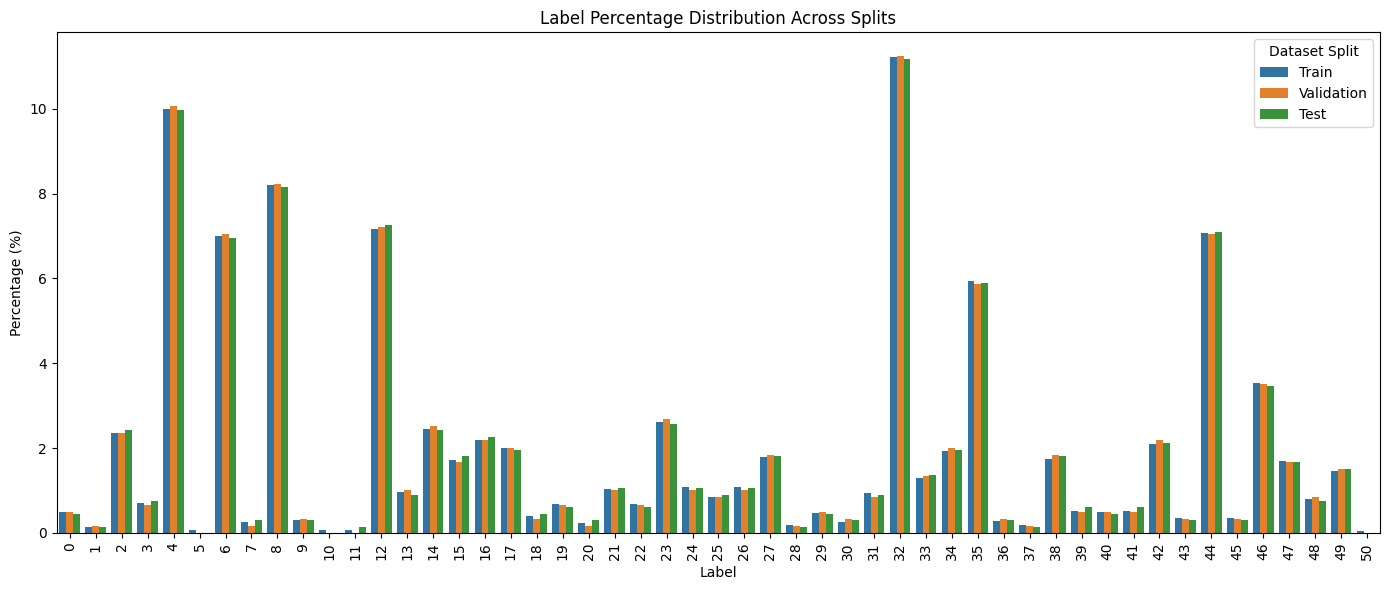

In [7]:
def plot_label_distribution(df, title):
    plt.figure(figsize=(12, 5))
    sns.countplot(x='label', data=df, order=sorted(df['label'].unique()))
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_label_percentage_distribution(df, title):
    label_counts = df['label'].value_counts(normalize=True).sort_index() * 100
    plt.figure(figsize=(12, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(title)
    plt.xlabel("Label")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


def get_label_percentages(df, split_name):
    percentages = df['label'].value_counts(normalize=True).sort_index() * 100
    return pd.DataFrame({
        'Label': percentages.index,
        'Percentage': percentages.values,
        'Split': split_name
    })

# Combine all splits into one DataFrame
df_all = pd.concat([
    get_label_percentages(train_df, 'Train'),
    get_label_percentages(val_df, 'Validation'),
    get_label_percentages(test_df, 'Test')
])

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_all, x='Label', y='Percentage', hue='Split')
plt.title("Label Percentage Distribution Across Splits")
plt.xlabel("Label")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=90)
plt.legend(title='Dataset Split')
plt.tight_layout()
plt.show()


In [4]:
# define tokenization logic
# This function takes a dictionary (like the items of our dataset) and returns
# a new dictionary with the keys input_ids, attention_mask, and token_type_ids

def safe_str(x):
    if x is None:
        return ""
    return str(x)

def tokenize_function(examples):
    subjects = [safe_str(s) for s in examples["subject"]]
    texts = [safe_str(t) for t in examples["text"]]
    return tokenizer(subjects, texts, truncation=True)

In [5]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenize the dataset
tokenized_datasets = final_splits.map(tokenize_function, batched=True)
print(tokenized_datasets)

# Our tokenize_function returns a dictionary with the keys input_ids, attention_mask,
# and token_type_ids, so those three fields are added to all splits of our dataset.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5359 [00:00<?, ? examples/s]

Map:   0%|          | 0/596 [00:00<?, ? examples/s]

Map:   0%|          | 0/662 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'subject', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5359
    })
    validation: Dataset({
        features: ['id', 'label', 'subject', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 596
    })
    test: Dataset({
        features: ['id', 'label', 'subject', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 662
    })
})


In [6]:
tokenized_datasets.save_to_disk("./tokenized_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/5359 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/596 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/662 [00:00<?, ? examples/s]

# Fine-tune

In [8]:
# The second step is to define our model. As in the previous chapter, we will use the
# AutoModelForSequenceClassification class, with two labels:

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=51)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


This will start the fine-tuning (which should take a couple of minutes on a GPU) and report the training loss every 500 steps. It won’t, however, tell you how well (or badly) your model is performing. This is because:

We didn’t tell the Trainer to evaluate during training by setting eval_strategy in TrainingArguments to either "steps" (evaluate every eval_steps) or "epoch" (evaluate at the end of each epoch).
We didn’t provide the Trainer with a compute_metrics() function to calculate a metric during said evaluation (otherwise the evaluation would just have printed the loss, which is not a very intuitive number).

In [9]:
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Change to "eval_loss" if preferred
    greater_is_better=True,            # Set to False if using loss
    logging_dir="./logs",
    logging_strategy="epoch",
    report_to="wandb"  # Enable default logging (e.g., to WandB)
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [10]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: musabumair005 (musabumair0191) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,1.825700,0.914051,0.800336
2,0.616600,0.499997,0.904362
3,0.280200,0.333865,0.932886
4,0.147800,0.273689,0.946309
5,0.082200,0.295922,0.946309
6,0.048500,0.263307,0.951342
7,0.032200,0.269442,0.947987
8,0.022900,0.254878,0.956376
9,0.017900,0.251464,0.951342
10,0.015800,0.262154,0.953020


TrainOutput(global_step=6700, training_loss=0.3089602450470426, metrics={'train_runtime': 6037.8559, 'train_samples_per_second': 8.876, 'train_steps_per_second': 1.11, 'total_flos': 1.4067095801762016e+16, 'train_loss': 0.3089602450470426, 'epoch': 10.0})

In [11]:
# Evaluate
test_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")

Test Accuracy: 0.9547
